In [ ]:
!pip install --upgrade efficientnet-pytorch

In [3]:
%matplotlib inline
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from efficientnet_pytorch import EfficientNet

import matplotlib.pyplot as plt

import torchvision.transforms as transforms

import copy

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imsize = 224

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

unloader = transforms.ToPILImage()

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

In [5]:
def gram_matrix(input):
  batch_size , h, w, f_map_num = input.size()  # batch size(=1)
  # f_map_num=number of feature maps
  # (h,w)=dimensions of a feature map (N=h*w)

  features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

  G = torch.mm(features, features.t())  # compute the gram product

  # we 'normalize' the values of the gram matrix
  # by dividing by the number of element in each feature maps.
  return G.div(batch_size * h * w * f_map_num)

class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    self.target = target.detach()
    self.loss = F.mse_loss(self.target, self.target )

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()
    self.loss = F.mse_loss(self.target, self.target)# to initialize with something

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

class EfficientNetNormalization(nn.Module):
  def __init__(self, device=None):
    super(EfficientNetNormalization, self).__init__()
    self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)

    if device is not None:
      self.mean = self.mean.to(device)
      self.std = self.std.to(device)

  def forward(self, input):
    return (input - self.mean) / self.std

In [6]:
class NST_EfficientNet(nn.Module):
  def __init__(self, content_input, style_inputs, cl_blocks_count, sl_blocks_count, device=None):
    super(NST_EfficientNet, self).__init__()

    self.model, self.content_loss_layers, self.style_loss_layers = \
      self._build_model(content_input, style_inputs, cl_blocks_count, sl_blocks_count, device)

  def _build_model(self, content_input, style_inputs, cl_blocks_count, sl_blocks_count, device=None):
    model = nn.Sequential()

    normalization = EfficientNetNormalization(device)
    if device is not None:
      normalization = normalization.to(device)
    model.add_module('normalization', normalization)
    
    cl_layers = []
    sl_layers = []
    backbone = EfficientNet.from_pretrained('efficientnet-b1')
    if device is not None:
      backbone = backbone.to(device)
    backbone = copy.deepcopy(backbone.eval())
    for layer_name, layer in backbone.named_children():
      if isinstance(layer, nn.ModuleList):
        for block_name, block in layer.named_children():
          if cl_blocks_count > 0 or sl_blocks_count > 0:
            # Add efficientnet conv block
            model.add_module('block_{}'.format(block_name), block)

            if cl_blocks_count > 0:
              block_output = model(content_input).detach()
              cl_layer = ContentLoss(block_output)
              # Add content loss layer after corresponding efficientnet block
              model.add_module('content_loss_{}'.format(block_name), cl_layer)
              cl_layers.append(cl_layer)
            if sl_blocks_count > 0:
              sl_layers.append([])
              for i in range(len(style_inputs)):
                style_input = style_inputs[i]
                block_output = model(style_input).detach()
                sl_layer = StyleLoss(block_output)
                # Add style loss layer after corresponding efficientnet block
                model.add_module('style_loss_{}_{}'.format(block_name, i), sl_layer)
                sl_layers[len(sl_layers)-1].append(sl_layer)

            cl_blocks_count -= 1
            sl_blocks_count -= 1
          else:
            # Exit
            break

        if cl_blocks_count > 0 or sl_blocks_count > 0:
          raise RuntimeError('Block count too large')

        # Exit
        break
      else:
        # Add all efficientnet early layers
        model.add_module("efficient_net{}".format(layer_name), layer)

    return model, cl_layers, sl_layers

  def forward(self, input):
    return self.model(input)

In [7]:
run = 0
def do_stuff(content_image_path, style_image_path, num_steps, content_weight, style_weights, verbose):
  global run
  style_imgs = []
  for path in style_image_path:
    style_imgs.append(image_loader(path))
  content_img = image_loader(content_image_path)
  input_img = content_img.clone()

  if verbose:
    print('Device is {}'.format(device))

  optimizer = optim.LBFGS([input_img.requires_grad_()])

  model = NST_EfficientNet(content_img, style_imgs, cl_blocks_count=1, sl_blocks_count=5, device=device)
  model = model.to(device)

  run = 0
  while run <= num_steps:
      def closure():
          global run
          input_img.data.clamp_(0, 1)

          optimizer.zero_grad()

          model(input_img)

          style_score = 0
          content_score = 0

          for style_loss_layer in model.style_loss_layers:
            for i in range(len(style_loss_layer)):
              style_score += style_loss_layer[i].loss * style_weights[i]
          for cl in model.content_loss_layers:
            content_score += cl.loss * content_weight

          loss = style_score + content_score
          loss.backward()

          run += 1
          if run % 100 == 0 and verbose:
              print("run {}:".format(run))
              print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                  style_score.item(), content_score.item()))
              print()

          return style_score + content_score

      optimizer.step(closure)

  input_img.data.clamp_(0, 1)

  plt.figure(figsize=(12, 4))
  for i in range(len(style_imgs)):
    plt.subplot(1, len(style_imgs), i+1)
    style_img = style_imgs[i]
    imshow(style_img, title='Style Image')
  plt.show()

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  imshow(content_img, title='Content Image')
  plt.subplot(1, 2, 2)
  imshow(input_img, title='Output Image')
  plt.show()


Device is cpu
Loaded pretrained weights for efficientnet-b1
run 100:
Style Loss : 102.162384 Content Loss: 20.409988

run 200:
Style Loss : 7.179521 Content Loss: 19.278828

run 300:
Style Loss : 2.005928 Content Loss: 17.301662



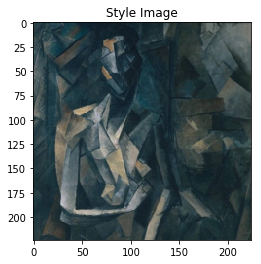

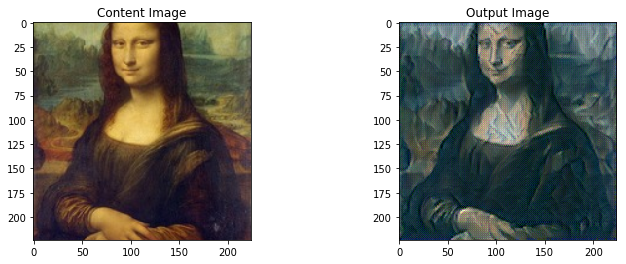

CPU times: user 1min 7s, sys: 2.77 s, total: 1min 10s
Wall time: 27.1 s


In [8]:
%%time
do_stuff('images/lisa.jpg', ['images/picasso.jpg'], \
         num_steps=300, content_weight=1, style_weights=[10000], verbose=True)

Device is cpu
Loaded pretrained weights for efficientnet-b1
run 100:
Style Loss : 95578.304688 Content Loss: 51.284389

run 200:
Style Loss : 94867.882812 Content Loss: 53.201088

run 300:
Style Loss : 94763.960938 Content Loss: 54.051655



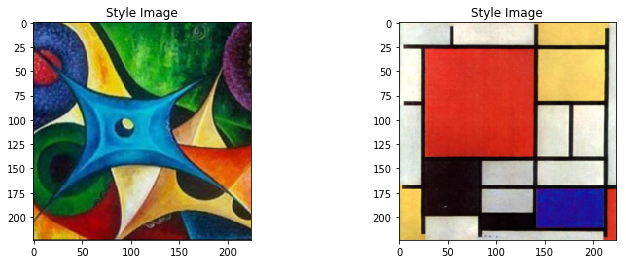

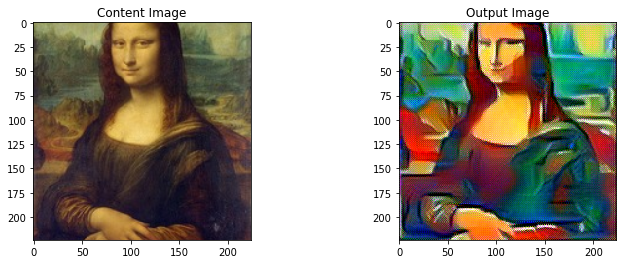

CPU times: user 1min 7s, sys: 2.63 s, total: 1min 9s
Wall time: 26.1 s


In [11]:
%%time
do_stuff('images/lisa.jpg', ['images/abs.jpg', 'images/abs2.jpg'], \
         num_steps=300, content_weight=1, style_weights=[10000, 5000], verbose=True)